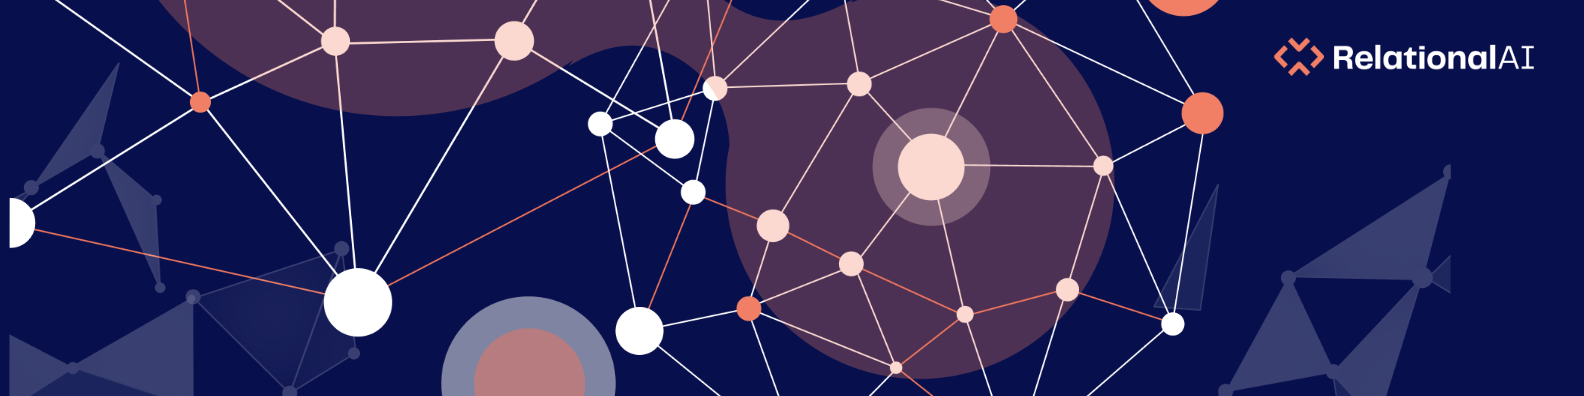

# Weakly Connected Components

The `weakly_connected_component` function computes the [weak component](https://en.wikipedia.org/wiki/Weak_component) to which each node in a graph belongs to.

In the analysis of social networks, for instance, it can often be useful to identify subgroups of connected people. These subgroups can be detected by using an algorithm such as weakly connected components (WCC).

Let us look at a very small example social graph and use WCC to identify which people belong to which subgroups.

Our graph will model a social network in which people can follow other people. To be part of a weakly connected component, one must either follow another person, or be followed by someone.

First, we need to import the `relationalai` library and define our model, which we call `MyWCCGraph`. We also create a type called `Person`.


In [1]:
def install_packages():
    import os
    os.system('pip install relationalai')

install_packages()


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import relationalai as rai
from relationalai.std import alias
from relationalai.std.graphs import Graph

model = rai.Model("MyWCCGraph")
Person = model.Type("Person")

## Let's add some data to our model
We first create a dictionary of people and who they follow. Then we iterate over the dictionary to create objects of type `Person` with a `name` property. We also set a `follows` property that we use to connect the various nodes in our graph.

In [3]:
following = {
    "Mary": ["Bob", "Frank"],
    "Bob": ["Frank"],
    "Frank": ["Bob"],
    "Jessy": ["Erica", "Tom", "Ed"],
    "Erica": ["Jessy", "Tom", "Ed"],
    "Tom": ["Jessy", "Erica", "Ed"],
    "Ed": ["Jessy", "Erica", "Tom"],
}

with model.rule(dynamic = True):
    for (name, follows) in following.items():
        person = Person.add(name = name)
        for other_name in follows:
            person.follows.add(Person.add(name = other_name))

## Creating the graph
Let's start by creating a `graph` with `Node` and `Edge` collections. We add all `Person` instances as nodes, and assign the `name` property so that we can use them in our queries and for visualization purposes. The `follows` property is then used to form the `edges` in our graph.

In [4]:
# Create graph
graph = Graph(model)
Node, Edge = graph.Node, graph.Edge

# add all Person instances as Nodes, assign `name` property (for displaying)
Node.extend(Person, name = Person.name)

# add all `follows` properties as Edges
Edge.extend(Person.follows)

## Running the algorithm
Let's add a rule that calculates for every node of the graph the component that it `belongs_to`. To derive this value for each node using the weakly connected component algorithm, we can simply use `Graph(model).compute.weakly_connected_component()`.

In [5]:
# run weakly connected components algorithm on the Graph,
# for every Person node assign the component it belongs to
with model.rule():
    p = Person()
    component = graph.compute.weakly_connected_component(p)
    p.set(belongs_to = component)
    Node(p).set(component = component)

## Querying the Graph
Graph Nodes, Edges and their properties are queried using `model.query()` context and `graph.Node()` or `graph.Edge()` types.

Alternatively, the entire graph representation can be fetched using `Graph(model).fetch()`. This returns a dictionary with two keys, `nodes` and `edges`, that represents the entire graph.

In [6]:
# query all Edges with `name` and `component` properties of the Nodes they connect
with model.query() as select:
    e = Edge()
    n1 = Node(e.from_)
    n2 = Node(e.to)
    response = select(alias(n1.name, 'from'), alias(n1.component, 'component (from)'), alias(n2.name, 'to'), alias(n2.component, 'component (to)'))

response

# fetch the entire graph dictionary (not recommended to be used for large graphs)
# graph_dict = graph.fetch()

from,component (from),to,component (to)
Bob,uA7RD0oPIwfSuk2XxzcGTA,Frank,uA7RD0oPIwfSuk2XxzcGTA
Ed,5JIaZtIEnepU6NNcSYpJUw,Erica,5JIaZtIEnepU6NNcSYpJUw
Ed,5JIaZtIEnepU6NNcSYpJUw,Jessy,5JIaZtIEnepU6NNcSYpJUw
Ed,5JIaZtIEnepU6NNcSYpJUw,Tom,5JIaZtIEnepU6NNcSYpJUw
Erica,5JIaZtIEnepU6NNcSYpJUw,Ed,5JIaZtIEnepU6NNcSYpJUw
Erica,5JIaZtIEnepU6NNcSYpJUw,Jessy,5JIaZtIEnepU6NNcSYpJUw
Erica,5JIaZtIEnepU6NNcSYpJUw,Tom,5JIaZtIEnepU6NNcSYpJUw
Frank,uA7RD0oPIwfSuk2XxzcGTA,Bob,uA7RD0oPIwfSuk2XxzcGTA
Jessy,5JIaZtIEnepU6NNcSYpJUw,Ed,5JIaZtIEnepU6NNcSYpJUw
Jessy,5JIaZtIEnepU6NNcSYpJUw,Erica,5JIaZtIEnepU6NNcSYpJUw


### How many weakly connected components were found? And to which component do people belong to?

In [7]:
# For each Person, fetch the name and the component it belongs to
with model.query() as select:
    p = Person()
    response = select(p.name, p.belongs_to)

# Group the response from the above query by the belongs_to property to separate the weakly connected components
components = response.results.groupby("belongs_to").name.apply(list)

# Print the number of weakly connected components
count_components = len(components)
print(f"Number of weakly connected components: {count_components}")

# Print all weakly connected components and the nodes in each component
for i, component in enumerate(components):
    print(f"Component {i+1}: {component}")

Number of weakly connected components: 2
Component 1: ['Ed', 'Erica', 'Jessy', 'Tom']
Component 2: ['Bob', 'Frank', 'Mary']


### Let's find out who belongs to the same component as Jessy

In [9]:
person_name = "Jessy"

with model.query() as select:
    p = Person(name = person_name)
    connection = Person()
    # We want to skip the person itself
    p != connection
    p.belongs_to == connection.belongs_to
    response = select(connection.name)

response

name
Ed
Erica
Tom


## Visualizing the results
As a final step, let's visualize our graph, to better understand the results. We use `Graph(model).visualize()` to visualize our graph and define a color for each of the components.

In [10]:
graph.visualize(three = False, style = {
    "node": {
        "color": lambda n : ['blue', 'pink'][ list(components.keys()).index(n['component']) % 2 ],
        "label": lambda n : n['name'],
        "size": 30
    },
    "edge": {
        "color": "green",
    }
}).display(inline = True)